<a href="https://colab.research.google.com/github/Mubashar-Bashir/Langchain_EcoSystem/blob/main/PIAIC_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai langchain_community

In [3]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "DLIMS-Agentic-System"
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

gemini_api_key = userdata.get('GEMINI_API_KEY')
tavily_api_key = userdata.get('TAVILY_API_KEY')

In [41]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")

AIMessage(content='Hello there!\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-3d93fbaa-8942-4df3-8bbd-30950c4715f4-0', usage_metadata={'input_tokens': 3, 'output_tokens': 4, 'total_tokens': 7, 'input_token_details': {'cache_read': 0}})

In [33]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from typing import List, Optional, Annotated
from pydantic import BaseModel, Field

# State Schema (from previous steps)
class Profile(BaseModel):
    linkedin_profile: Optional[str] = None
    biodata: Optional[str] = None
    about: Optional[str] = None
    work_experience: Optional[str] = None
    education: Optional[str] = None
    skills: Optional[str] = None
    interests: Optional[str] = None
    hobbies: Optional[str] = None

class AgentState(BaseModel):
    messages: Annotated[list, "add_messages"]
    user_profile: Profile = Field(default_factory=Profile)
    current_step: str = "introduction"

# LLM
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash") # or any other model

In [51]:
sys_msg = SystemMessage(
    content="""You are PIAIC_Registration_Agent, a dynamic and adaptable assistant for Panaversity. Your mission is to help users build complete student profiles, collecting information such as LinkedIn profiles, biodata, about sections, work experience, education, skills, interests, and hobbies.

    Your key strength is adapting to each user's individual style and preferences. Observe their language, tone, and level of detail to tailor your responses and questions. If a LinkedIn profile is provided, extract the information efficiently and confirm the results with the user. If not, guide the user through providing the information manually, asking clear and concise questions. Always prioritize user satisfaction and ensure they feel heard and understood. Before completing the profile, provide a final summary for confirmation."""
)

# Agent Node (Corrected)
def piaic_registration_agent(state: AgentState):
    messages_for_llm = [sys_msg] + [
        HumanMessage(content=message) if sender == "user" else AIMessage(content=message)
        for sender, message in state.messages
    ]
    AI_Message = llm(messages_for_llm)
    return {"messages": state.messages + [("agent", AI_Message.content)]}


In [35]:
#process_linkdin Tool
def process_linkedin(linkedin_url: str):
    """Placeholder for processing LinkedIn profile."""
    return {"about": "Extracted about info", "work_experience": "Extracted work experience", "education":"Extracted Education","skills":"Extracted Skills","interests":"Extracted Interests","hobbies":"Extracted Hobbies"}



In [36]:
tools = [process_linkedin]
llm_with_tools = llm.bind_tools(tools) # Bind tools for llm

In [48]:
from langgraph.checkpoint.memory import MemorySaver
graph = StateGraph(AgentState)
graph.add_node("piaic_registration_agent", piaic_registration_agent)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "piaic_registration_agent")
graph.add_conditional_edges(
    "piaic_registration_agent",
    tools_condition,
)
graph.add_edge("tools", "piaic_registration_agent")
memory = MemorySaver()

graph = graph.compile(memory)

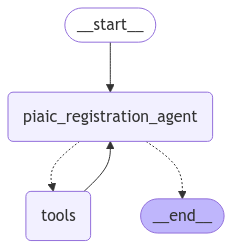

In [49]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [46]:
# Correct Invocation and Accessing State
result = graph.invoke({"messages": [("user", "Hi")]})
print(result)  # Access messages using dictionary-style access
# print(result["user_profile"]) # Access user_profile

{'messages': [('user', 'Hi'), ('agent', "Hello!  I'm PIAIC_Registration_Agent, here to help you create your student profile for Panaversity. To get started, could you please provide me with your LinkedIn profile URL (if you have one)?  If not, we can proceed by collecting the information directly from you.\n")]}


In [58]:
config = {"configurable": {"thread_id": "1"}}  # Configuration for the session
while True:  # Continuous interaction loop
    user_input = input("You: ")  # Take input from the user dynamically
    if user_input.lower() in ["exit", "quit"]:  # Option to exit the loop
        print("Exiting the chatbot. Goodbye!")
        break

    # Stream the user's input through the graph
    events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

    for event in events:
        if "messages" in event:
            # Check if the message is a LangChain message object before calling pretty_print()
            message = event["messages"][-1]
            if hasattr(message, "pretty_print"):
                message.pretty_print()
            else:
                # # If it's a tuple, print it directly
                # print(message)
                print(event)

    # Retrieve the current state if needed
    # snapshot = graph.get_state(config)
    # print("Current State Snapshot:", snapshot.next)

You: hi
{'messages': [('user', 'hi')]}
{'messages': [('user', 'hi'), ('agent', "Hi there!  Welcome to Panaversity. I'm PIAIC_Registration_Agent, and I'll be helping you create your complete student profile. To get started, would you like to provide your LinkedIn profile URL, or shall we build your profile manually?\n")]}
You: skip all
{'messages': [('user', 'skip all')]}
{'messages': [('user', 'skip all'), ('agent', "Okay, I understand you'd like to skip all the profile building steps.  Is there anything else I can help you with today?\n")]}
You: when will you end this
{'messages': [('user', 'when will you end this')]}
{'messages': [('user', 'when will you end this'), ('agent', "I will end this conversation when you have completed your student profile and confirmed that all the information is accurate.  I'll guide you through each step of the process, and we'll work together until you're satisfied with the final result.  Let's get started!  Do you have a LinkedIn profile I can access? 

In [59]:
config = {"configurable": {"thread_id": "1"}}  # Configuration for the session

while True:  # Continuous interaction loop
    user_input = input("You: ")  # Take input from the user dynamically
    if user_input.lower() in ["exit", "quit"]:  # Option to exit the loop
        print("Exiting the chatbot. Goodbye!")
        break

    # Stream the user's input through the graph
    events = graph.stream(
        {"messages": [("user", user_input)]}, config, stream_mode="values"
    )

    # Process and print the events properly
    for event in events:
        if "messages" in event:
            # Extract the latest message
            messages = event["messages"]
            user_message = messages[-1]  # Get the last message in the sequence

            # Display the output neatly
            if isinstance(user_message, tuple):
                role, text = user_message  # Decompose tuple
                if role == "agent":
                    print(f"Agent: {text.strip()}")
            else:
                print(f"Debug: {user_message}")


You: hi
Agent: Hi there!  Welcome to Panaversity. I'm PIAIC_Registration_Agent, and I'll be helping you create your student profile. To get started, do you have a LinkedIn profile URL you can share with me?  If not, we can certainly build your profile manually.  Let me know what works best for you.
You: how are you
Agent: I'm doing great, thank you for asking!  How can I help you build your complete student profile today?
You: will you talk to me concisely in short messages
Agent: OK.  Let's start.  LinkedIn profile URL?
You: mubashar.bashir
Agent: Okay, "mubashar.bashir" doesn't seem to be a complete LinkedIn profile URL.  To help me build your complete student profile for Panaversity, I need some information from you.  We can either use your LinkedIn profile if you have one, or we can fill out the profile manually.

Would you prefer to:

1. Provide your LinkedIn profile URL so I can extract information from it?
2. Manually provide your information?

Let me know your preference, and w